## Libraries

In [106]:
from collections import Counter,defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
import json
from bs4 import BeautifulSoup
import sys
import os

#os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model, load_model
from keras.callbacks import Callback

from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

import re

## Load-In Data/Pre-process

### Selection

In [87]:
testing = ["NB","SGD","LG","RF", "CNN", "CNNPlus"]

### Combined

In [88]:
def preprocess(article):
    article = article.encode('utf-8')
    article = str(article.lower())
    return removeTagsInterpuntion(article)

def removeTagsInterpuntion(article): #remove URL's, HTML-tags and interpuntion
    article = re.sub("^https?:\/\/.*[\r\n]*", '', article)
    article = re.sub('\\\\x\w\w', '', article)
    article = re.sub('[^a-z\s]', '', article)
    return article

def loadData(path, texts, labels, urls, highLevelLabels = True):
    with open(path) as data_file:    
        data = json.load(data_file)
    for article in data:
        text = preprocess(article["content"])
        if len(text.split()) > 9 and article["category"] != "NOCAT": #Remove small sentences
            if article["url"] not in urls:
                urls.append(article["url"])
                texts.append(text)
                if highLevelLabels:
                    label = article["category"].split("|")
                    labels.append(label[0])
                else:
                    labels.append(article["category"])
    return texts, labels, urls

In [89]:
texts = []
labels = []
urls = []
paths = [r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics_first.json",
         r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics_second.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics_2017.json",
        r"C:\Users\PC-Axel\Documents\github\thesis\Data\PoliFLW Data\kamerstukken_topics_2016.json"]

for path in paths:
    texts, labels, urls = loadData(path, texts, labels, urls)
    

#Prepare splitting
VALIDATION_SPLIT = 0.2
indices = np.arange(len(labels))
np.random.shuffle(indices)
texts = np.array(texts)[indices]
labels = np.array(labels)[indices]
nb_validation_samples = int(VALIDATION_SPLIT * labels.shape[0])

In [90]:
print(len(urls), len(labels))

29082 29082


### CNN

In [91]:
if "CNN" in testing or "CNNPlus" in testing:
    MAX_SEQUENCE_LENGTH = 1000
    MAX_NB_WORDS = 20000
    EMBEDDING_DIM = 160
    
    lb = preprocessing.LabelBinarizer()
    labelsCNN = lb.fit_transform(labels)

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labelsCNN.shape)

    x_train = data[:-nb_validation_samples]
    y_train = labelsCNN[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labelsCNN[-nb_validation_samples:]
    
    
    print('Class distribution in training and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))

Found 161810 unique tokens.
Shape of data tensor: (29082, 1000)
Shape of label tensor: (29082, 17)
Class distribution in training and validation set 
[1054  896 1861 1074  518 2262  709  924 1527 1254 2951 1347  169  684
 1310  717 4009]
[257 239 447 260 120 584 159 245 387 307 723 381  50 183 313 183 978]


### Baselines

In [125]:
if "NB" in testing or "SGD" in testing:
    xTrain = texts[:-nb_validation_samples]
    yTrain = labels[:-nb_validation_samples]
    xVal = texts[-nb_validation_samples:]
    yVal = labels[-nb_validation_samples:]
    
    transformer = TfidfVectorizer(smooth_idf=True, min_df=0.00000001, max_df=0.2, sublinear_tf=True)
    
    xTrain = transformer.fit_transform(xTrain)
    xVal = transformer.transform(xVal)
    everything = transformer.transform(texts)

In [95]:
def evaluation(yVal,yPred):
    print("Accuracy is " + str(accuracy_score(yVal, yPred)))
#     print(f1_score(yVal, yPred, average='macro'),f1_score(yVal, yPred, average='micro'), 
#         f1_score(yVal, yPred, average='weighted'))
#     print(precision_score(yVal, yPred, average='macro'),precision_score(yVal, yPred, average='micro'), 
#         precision_score(yVal, yPred, average='weighted'))
#     print(recall_score(yVal, yPred, average='macro'),recall_score(yVal, yPred, average='micro'), 
#         recall_score(yVal, yPred, average='weighted'))
#    print(classification_report(yVal, yPred))

In [25]:


if "NB" in testing:
    clf = MultinomialNB()
    clf = OneVsRestClassifier(clf)#.fit(xTrain, yTrain)
    #yPred = clf.predict(xVal)
    #evaluation(yVal,yPred)
    
    parameters = {
        "estimator__fit_prior": [True, False],
    }
    model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
    print(model_tunning.best_score_)
    print(model_tunning.best_params_ )


C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.21868821456202184
{'estimator__fit_prior': False}


In [26]:
if "SGD" in testing:
    clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=10, tol=None)
    clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
    yPred = clf.predict(xVal)
    evaluation(yVal,yPred)
    
    
#     parameters = {
#         "estimator__loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
#         "estimator__penalty": ["none", "l2", "l1", "elasticnet"],
#         "estimator__alpha": [0.0001,0.00001],
#     }
#     model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
#     print(model_tunning.best_score_)
#     print(model_tunning.best_params_ )

Accuracy is 0.7831843191196699


In [27]:
clf = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-5, max_iter=10, tol=None)
clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
yPred = clf.predict(xVal)
evaluation(yVal,yPred)

Accuracy is 0.8026134800550206


In [103]:
if "LG" in testing:
    clf = LogisticRegression(dual=False)
    clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
    yPred = clf.predict(xVal)
    evaluation(yVal,yPred)
    
    parameters = {
        #"estimator__penalty": ["I1", "I2"],
        "estimator__C": [0.001,0.01,0.1,1,10,100,1000],
    }
    model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
    print(model_tunning.best_score_)
    print(model_tunning.best_params_ )


Accuracy is 0.7305708390646493
0.8031892031290295
{'estimator__C': 1000}


In [104]:

if "RF" in testing:
    clf = RandomForestClassifier()
    clf = OneVsRestClassifier(clf).fit(xTrain, yTrain)
    yPred = clf.predict(xVal)
    evaluation(yVal,yPred)
    
    parameters = {
        "estimator__criterion": ["gini", "entropy"],
        "estimator__max_depth": [3,10,30],
        "estimator__n_estimators": [3,10,30]
    }
    model_tunning = GridSearchCV(clf, param_grid=parameters).fit(xTrain, yTrain)
    print(model_tunning.best_score_)
    print(model_tunning.best_params_ )

Accuracy is 0.7216299862448419


KeyboardInterrupt: 

In [105]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\PC-Axel\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

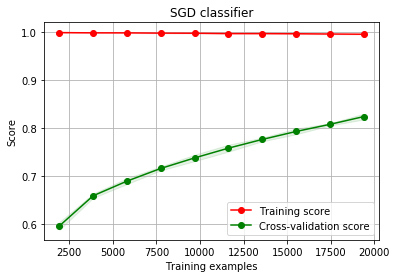

In [127]:
clf = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-5, max_iter=10, tol=None)
#clf = OneVsRestClassifier(clf)

plot_learning_curve(clf, "SGD classifier", everything, np.append(yTrain,yVal))

## Train Models and evaluate

### CNN

In [15]:
if "CNN" in testing or "CNN+" in testing:
    GLOVE_DIR = r"C:\Users\PC-Axel\Documents\Codeer projecten\Word2Vec Vectoren\Nederlandse word2vec\combined-160.txt"
    embeddings_index = {}
    f = open(GLOVE_DIR, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1442951 word vectors in Glove 6B 100d.


In [16]:
import keras
import numpy as np
import sklearn.metrics as sklm


class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []
        self.kappa = []
        self.auc = []

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        predict = lb.inverse_transform(predict, threshold=None)
        targ = self.validation_data[1]
        targ = lb.inverse_transform(targ, threshold=None)
        
        print(print(classification_report(targ, predict)))
        self.confusion.append(sklm.confusion_matrix(targ, predict))
        self.precision.append(sklm.precision_score(targ, predict, average=None))
        self.recall.append(sklm.recall_score(targ, predict, average=None))
        self.f1s.append(sklm.f1_score(targ, predict, average=None))

        return
metrics = Metrics()

In [31]:
if "CNN" in testing:
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(labelsCNN.shape[1], activation='softmax')(l_dense)

    modelCNN = Model(sequence_input, preds)
    modelCNN.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

(?, 3, 128)


ValueError: Negative dimension size caused by subtracting 35 from 3 for 'max_pooling1d_43/MaxPool' (op: 'MaxPool') with input shapes: [?,3,1,128].

In [35]:
if "CNN" in testing:
    print("modelCNN fitting - simplified convolutional neural network")
    modelCNN.summary()
    historyCNN = modelCNN.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=20, batch_size=128)#,callbacks=[metrics])

modelCNN fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 160)         25889760  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          102528    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)

In [36]:
if "CNNPlus" in testing:
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    # applying a more complex convolutional approach
    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(labelsCNN.shape[1], activation='softmax')(l_dense)

    modelCNNPlus = Model(sequence_input, preds)
    modelCNNPlus.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [37]:
if "CNNPlus" in testing:
    print("modelCNNPlus fitting - more complex convolutional neural network")
    modelCNNPlus.summary()
    historyCNNPlus = modelCNNPlus.fit(x_train, y_train, validation_data=(x_val, y_val),
              nb_epoch=20, batch_size=50)

C:\Users\PC-Axel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


modelCNNPlus fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 160)    25889760    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 128)     61568       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 997, 128)     82048       embedding_2[0][0]                
____________________________________________

In [42]:
modelCNN.save('models/CNN-Model-118')  # creates a HDF5 file 'my_model.h5'
with open('models/CNN-Model-118-History', 'wb') as file_pi:
    pickle.dump(historyCNN.history, file_pi)
    
modelCNNPlus.save('models/CNNPlus-Model-118')  # creates a HDF5 file 'my_model.h5'
with open('models/CNNPlus-Model-118-History', 'wb') as file_pi:
    pickle.dump(historyCNNPlus.history, file_pi)




In [33]:
##### Try splitting in parts of 200
newTexts = []
newLabels = []
newUrls = []
i = 0 
for text, label, url in zip(texts,labels, urls):
    chunks = [text.split()[x:x+200] for x in range(0, len(text.split()), 200)]
    newTexts.extend(chunks)
    newLabels.extend([label]*len(chunks))
    newUrls.extend([url]*len(chunks))
    i += 1
    if i > nb_validation_samples:
        new_nb_validation_samples = i

if "CNN" in testing or "CNNPlus" in testing:
    MAX_SEQUENCE_LENGTH = 200
    MAX_NB_WORDS = 80000
    EMBEDDING_DIM = 160
    
    lb = preprocessing.LabelBinarizer()
    labelsCNN = lb.fit_transform(newLabels)

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(newTexts)
    sequences = tokenizer.texts_to_sequences(newTexts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labelsCNN.shape)

    x_train = data[:-new_nb_validation_samples]
    y_train = labelsCNN[:-new_nb_validation_samples]
    x_val = data[-new_nb_validation_samples:]
    y_val = labelsCNN[-new_nb_validation_samples:]
    
    
    print('Class distribution in training and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))

Found 161810 unique tokens.
Shape of data tensor: (96263, 200)
Shape of label tensor: (96263, 17)
Class distribution in training and validation set 
[ 2741  2276  5669  3583  1430  5978  2007  2394  4622  3753  7713  3943
   549  2039  3707  2075 12702]
[1166 1116 2439 1580  697 2479  805 1118 1933 1675 3194 1649  241  980
 1790  865 5355]


In [36]:
if "CNN" in testing:
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    l_pool3 = MaxPooling1D(3)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool3)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(labelsCNN.shape[1], activation='softmax')(l_dense)

    modelCNN = Model(sequence_input, preds)
    modelCNN.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

In [74]:
print("modelCNN fitting - simplified convolutional neural network")
modelCNN.summary()
historyCNN = modelCNN.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=128)#,callbacks=[metrics])
modelCNN.save('models/CNN-splitup-Model-17')  # creates a HDF5 file 'my_model.h5'
with open('models/CNN-splitup-Model-17-History', 'wb') as file_pi:
    pickle.dump(historyCNN.history, file_pi)

modelCNN fitting - simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 200, 160)          25889760  
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 196, 128)          102528    
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 7, 128)            0         
_________________________________________________________________
conv1d_54 (Conv1D

In [75]:
def doPrediction(currentx,currenty,model):
    if currentx is "a":
        return
    prediction = model.predict(currentx)
    if prediction.sum(axis=0).argmax() == currenty.argmax():
        return 1
    else: return 0

In [77]:
print(x_val.shape, y_val.shape, len(newUrls[-new_nb_validation_samples:]))
currenturl = "a"
currenty = "a"
currentx = "a"
succes = []

for x,y,url in zip(x_val,y_val,newUrls[-new_nb_validation_samples:]):
    if url == currenturl:
        currentx = np.append(currentx,[x],axis=0)
    else:
        succes.append(doPrediction(currentx,currenty,modelCNN))
        #doPrediction(currentx,currenty,modelCNN)
        currentx = np.array([x])
        currenty = y
        currenturl = url


print(sum(succes[1:])/len(succes[1:]))        

(29082, 200) (29082, 17) 29082
0.75403456564038


## Evaluate Models

In [80]:
pkl_file = open('models/CNN-Model-118-History', 'rb')
historyCNN = pickle.load(pkl_file)

In [82]:
print(historyCNN)

{'val_loss': [3.4910919456403224, 3.1525334993779577, 2.667243994577715, 2.3720373195663935, 2.34587896148965, 2.235585916813007, 2.150476222517074, 2.243920987705089, 2.16680237072862, 2.203397887609028, 2.3994499784388275, 2.3879683727739276, 2.5540136964645805, 2.707935614959738, 2.761095232451962, 3.1933900335959917, 2.9779774642548174, 3.2217147614309845, 3.107745862072731, 3.9781631574014193], 'val_acc': [0.18535075657469371, 0.2233493809973849, 0.33459422275157547, 0.394944979244282, 0.3970082530129235, 0.4116231085017754, 0.4614855572478807, 0.47747592871913885, 0.5077372763147052, 0.5208046766717955, 0.5287138929557276, 0.5448762036583282, 0.5465955981034196, 0.5629298484472985, 0.551066024923259, 0.5441884455031509, 0.5751375517458175, 0.5675722148264291, 0.580123796505646, 0.5118638236880139], 'loss': [3.9408810306761564, 3.2275565665596013, 2.7100492090225057, 2.289512269343, 1.9682525998900662, 1.6922383360467999, 1.4391729142550476, 1.2143162031386034, 0.9946802210994306,

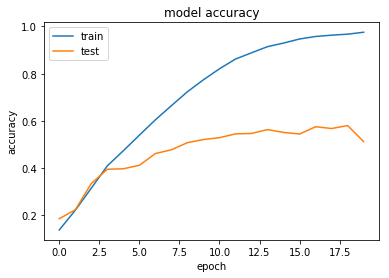

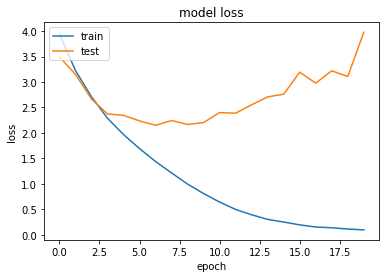

In [83]:
import matplotlib.pyplot as plt
plt.plot(historyCNN['acc'])
plt.plot(historyCNN['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyCNN['loss'])
plt.plot(historyCNN['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()